# Gradient-based optimization

## Overview

In this tutorial, we will build a simple example application that showcases differentiation and optimization of a light transport simulation. Our experiment will be very simply: we will first render a reference image of the Cornell Box scene before modifying the color of the red wall in that scene (e.g. to blue). Then we will try to recover the original color using differentiation along with the reference image previoulsy generated.

Mitsuba’s ability to automatically differentiate entire rendering algorithms builds on differentiable JIT array types provided by the Dr.Jit library. Those are explained in the [Dr.Jit documentation](...). The linked document also discusses key differences compared to superficially similar frameworks like PyTorch and TensorFlow. For *automatic differentiation* (AD), Dr.Jit records and simplifies computation graphs and uses them to propagate derivatives in forward or reverse mode. Before getting further into this tutorial, we recommend that you familiarize yourself this document.

<div class="admonition important alert alert-block alert-info">

🚀 **What will you learn?**
    
<ul>
  <li>Passing scene arguments when loading an XML file</li>
  <li>Build an optimization pipeline using the <tt>Optimizer<> classes</li>
  <li>Perform gradient-based optimization using automatic differentiation</li>
</ul>
    
</div>


### Step 1 - Setup

In order to use the automatic differentiation, we need to enable a variant that supports it. Those are the ones containing `_ad` after the backend description. E.g. `cuda_ad_rgb`, `llvm_ad_rgb`, ... 

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

As in the previous tutorials, we define a helper function to display the rendered images.

In [2]:
from matplotlib import pyplot as plt

def show_image(img, title):
    plt.imshow(mi.util.convert_to_bitmap(img)); plt.axis('off'); plt.title(title);

### Step 2 - Scene loading

Before loading the scene, let's note that in `cbox.xml` we expose some variables at the top of the file:

```xml
  <default name="spp" value="128"/>
  <default name="res" value="256"/>
  <default name="max_depth" value="6"/>
  <default name="integrator" value="path"/>
```

Those variables are later referenced in the XML file as explained in the [documentation](...) and can be assigned directly from Python when loading the scene, this using keyword arguments in the `load_file` function. This helpful feature let us change the film resolution and integrator type for this tutorial without editing the XML file.

For differentiable rendering application, we recommand to use the `prb` integrator introduced by <cite data-cite="Vicini2021">Vicini et al. (2021)</cite> which is equivalent to the `path` integrator for primal rendering.

In [3]:
scene = mi.load_file('../scenes/cbox.xml', res=128, integrator='prb')

2022-03-22 09:51:02 INFO main [xml.cpp:1260] Loading XML file "../scenes/cbox.xml" with variant "llvm_ad_rgb"..

2022-03-22 09:51:02 INFO main [Scene] Embree ready. (took 5ms)

2022-03-22 09:51:02 INFO main [xml.cpp:1319] Done loading XML file "../scenes/cbox.xml" (took 17ms).

### Step 3 - Reference image

We render a reference image of the original scene that will later be used in the objective function for the optimization. Ideally, this reference image should expose very little noise as it will pertube optimization process otherwise. Hence we render this image with a higher sample count.

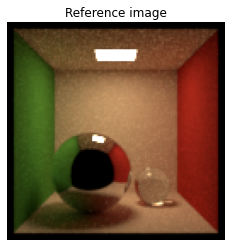

In [4]:
image_ref = mi.render(scene, seed=0, spp=512)
show_image(image_ref, 'Reference image')

### Step 4 - Initial state

Using the traverse mechanism, we can pick a parameter to optimize and change its value. The goal of the optimization process will be to recover the original value of this parameter using a gradient descent.

For later comparison, we also save the original value of the scene parameter.

In [5]:
# Update scene parameter and only keep the parameter of interest
params = mi.traverse(scene)
key = 'red.reflectance.value'

# Save the original value
param_ref = mi.Color3f(params[key])

# Set another color value and update the scene
params[key] = mi.Color3f(0.01, 0.2, 0.9)
params.update()

As expected, when rendering the scene again, the wall has changed color.

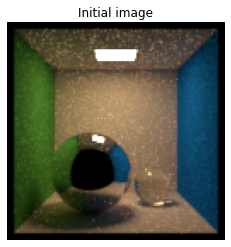

In [6]:
# Render initial image
image_init = mi.render(scene, seed=0, spp=128)
show_image(image_init, 'Initial image')

### Step 4 - Optimization

For gradient-based optimization, Mitsuba ships with standard optimizers including *Stochastic Gradient Descent* (`SGD`) with and without momentum, as well as `Adam` <cite data-cite="kingma2014adam">[KB14]</cite>. We will instantiate the latter and optimize our scene parameter with a learning rate of `0.05`. 

During the optimization process, the optimizer will always perfom gradient steps on copies of the parameters to optimize. To propagate those changes to the scene, we need to call the `update()` method which will copy those values back into the `params` data structure passed in the constructor and internally call `params.update()`.

In the following code, the second line copies the scene parameter into the optimizer state, which will automatically enable gradient tracking on this variable.

For more detailed explanation on how-to-use the optimizer classes, please refer to the dedicated [how-to-guide](...).

In [7]:
opt = mi.ad.Adam(lr=0.05, params=params)
opt[key] = params[key]
opt.update()

At every iteration of the gradient descent, we will compute the derivatives of the scene parameters with respect to the objective function. In this simple experiment, we use the *Mean Square Error* objective function defined below.

In [8]:
# Objective function
def MSE(image):
    return dr.hmean_async(dr.sqr(image - image_ref))

It is now time to actually perform the gradient-descent loop that executes 50 differentiable rendering iterations.

In [9]:
mi.set_log_level(mi.LogLevel.Error)

errors = []
for it in range(50):
    # Perform a differentiable rendering of the scene
    image = mi.render(scene, params, spp=4)
    
    # Evaluate the objective function
    loss = MSE(image)

    # Backpropagate through the whole process
    dr.backward(loss)

    # Optimizer: Take a gradient step
    opt.step()

    # Post-process the optimized parameters
    opt[key] = dr.clamp(opt[key], 0.0, 1.0)

    # Optimizer: Update the scene parameters
    opt.update()

    err_ref = dr.hsum(dr.sqr(param_ref - params[key]))
    print(f'Iteration {it:2} error={err_ref[0]:.4f}')
    errors.append(err_ref)

Iteration  0 error=0.9207
Iteration  1 error=0.7864
Iteration  2 error=0.6674
Iteration  3 error=0.5628
Iteration  4 error=0.4693
Iteration  5 error=0.3853
Iteration  6 error=0.3116
Iteration  7 error=0.2482
Iteration  8 error=0.1944
Iteration  9 error=0.1499
Iteration 10 error=0.1139
Iteration 11 error=0.0855
Iteration 12 error=0.0636
Iteration 13 error=0.0473
Iteration 14 error=0.0356
Iteration 15 error=0.0276
Iteration 16 error=0.0224
Iteration 17 error=0.0192
Iteration 18 error=0.0173
Iteration 19 error=0.0162
Iteration 20 error=0.0154
Iteration 21 error=0.0150
Iteration 22 error=0.0138
Iteration 23 error=0.0115
Iteration 24 error=0.0091
Iteration 25 error=0.0070
Iteration 26 error=0.0052
Iteration 27 error=0.0038
Iteration 28 error=0.0030
Iteration 29 error=0.0025
Iteration 30 error=0.0024
Iteration 31 error=0.0027
Iteration 32 error=0.0032
Iteration 33 error=0.0038
Iteration 34 error=0.0045
Iteration 35 error=0.0052
Iteration 36 error=0.0057
Iteration 37 error=0.0060
Iteration 38

### Step 5 - Results

We can now render the scene again to check whether the optimization process successfully recovered the color of the red wall.

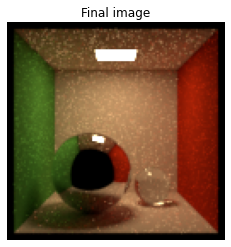

In [10]:
image_final = mi.render(scene, seed=0)
show_image(image_final, 'Final image')

We can also plot the error during each iteration. Note that it makes little sense to visualize the objective values, since differences between `image` and `image_ref` are by far dominated by Monte Carlo noise that is not related to the parameter being optimized. Since we know the “true” target parameter in this scene, we can validate the convergence of the iteration:

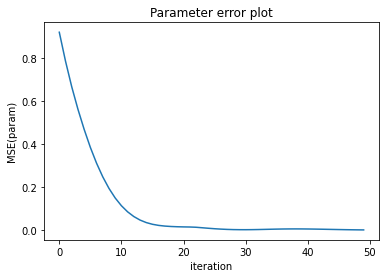

In [11]:
plt.plot(errors)
plt.xlabel('iteration'); plt.ylabel('MSE(param)'); plt.title('Parameter error plot');

### *Reference API*

- [<code>mitsuba.core.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.load_file)